# Подбор признаков

## Импорт всего, что надо

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score,cross_validate, train_test_split

from sklearn.metrics import precision_score, fbeta_score, f1_score, recall_score
from sklearn import metrics
from sklearn.metrics import make_scorer, confusion_matrix

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.cluster import DBSCAN
from sklearn.base import BaseEstimator 
from sklearn.base import ClassifierMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Получаем данные

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cup_it_data.csv', index_col = 'client_id')

Создаем множество для хранения всех категорий товаров, это нам пригодится попозже

In [35]:
# категории товаров
categories = set()
for col in data.columns:
    for n in range(1, 13):
        if f'cnt_checks_{n}_' in col or f'rto_{n}_' in col or f'rto_std_{n}_' in col:
            cat = col.split('_')[-1]
            categories.add(cat)

categories

{'Крупы и зерновые',
 'Мясная гастрономия',
 'Овощи - Фрукты',
 'Птица и изделия из птицы',
 'Рыба и рыбные изделия',
 'Сыры'}

In [36]:
# это все наши столбцы
cols = {
    'client_id': 'client_id',
    'rto_n': [f'rto_{n}' for n in range(6, 13)],
    'rto_n_category': [f'rto_{n}_{cat}' for n in range(6, 13) for cat in categories],
    'rto_std_n': [f'rto_std_{n}' for n in range(6, 13)],
    'rto_std_n_category': [f'rto_stddev_{n}_{cat}' for n in range(6, 13) for cat in categories],
    'cnt_checks_n': [f'cnt_checks_{n}' for n in range(6, 13)],
    'cnt_checks_n_category': [f'cnt_checks_{n}_{cat}' for n in range(6, 13) for cat in categories],
    'is_in_club': 'is_in_club'
}

## Подготовка данных

### Заполнение пропусков

In [37]:
# на всякий заполним пропуски
data = data.fillna(0)

### Обработка отрицательных значений

У нас в датасете часто встречаются отрицательные значения, причем с столбцах, где их быть не может - в стандартном отклонении. Таких экзмепляров более 9%, что довольно много, поэтому просто выкинуть мы их не можем. 

Зато мы можем создать новые столбцы - возвести в квадрат сатндартные отклонения и получить дисперсию.

In [38]:
# создание новых столбцов
for n in range(6, 13):
    data[f'rto_var_{n}'] = data[f'rto_std_{n}']**2

for cat in categories:
    for n in range(6, 13):
        data[f'rto_var_{n}_{cat}'] = data[f'rto_stddev_{n}_{cat}']**2

In [39]:
# добавление новых столбцов в словарь столбцов
cols = {
    'client_id': 'client_id',
    'rto_n': [f'rto_{n}' for n in range(6, 13)],
    'rto_n_category': [f'rto_{n}_{cat}' for n in range(6, 13) for cat in categories],
    'rto_std_n': [f'rto_std_{n}' for n in range(6, 13)],
    'rto_std_n_category': [f'rto_stddev_{n}_{cat}' for n in range(6, 13) for cat in categories],
    'cnt_checks_n': [f'cnt_checks_{n}' for n in range(6, 13)],
    'cnt_checks_n_category': [f'cnt_checks_{n}_{cat}' for n in range(6, 13) for cat in categories],
    'is_in_club': 'is_in_club',
    'rto_var_n': [f'rto_var_{n}' for n in range(6, 13)],
    'rto_var_n_category': [f'rto_var_{n}_{cat}' for n in range(6, 13) for cat in categories],
}

Также отрицательные значения встречаются в категории `rto`, но выкинуть мы их тоже не можем, да и отклонения у них небольшие, поэтому просто заменим их на 0.

In [40]:
for col in [cols['rto_n'] + cols['rto_n_category']]:
    data[col] = np.where(data[col]>=0, data[col], 0)

### Логарифмирование

Поскольку большинство столбцов у нас имеют логнормальное распределение, было бы не плохо их логарифмировать. Тогда получится нормальное распределение и модель, вероятно, будет лучше работать.

In [41]:
data_log_all = np.log1p(data)
# при этом мы не хотим получить ошибку, ведь в колонках стд есть отрицательные значения
data_log_all = data_log_all.drop(columns=cols['rto_std_n'] + cols['rto_std_n_category'])

# целевую переменную логарифмировать не надо, иначе будет бардак
data_log_all['is_in_club'] = data['is_in_club'].copy()

При этом у нас есть дискретные столбцы, которые, вероятно, не стоит логарифмировать.

In [42]:
rto_columns = cols['rto_n'] + cols['rto_n_category'] + cols['rto_var_n'] + cols['rto_var_n_category']

In [43]:
# сначала копируем весь датасет
data_log_rto = data.copy()
# затем логарифмируем только нужные колонки
data_log_rto[rto_columns] = np.log1p(data_log_rto[rto_columns])
# затем удаляем ненужные колонки, которые скорее всего сделают качество только хуже
data_log_rto = data_log_rto.drop(columns=cols['rto_std_n'] + cols['rto_std_n_category'])

Посмотрим на то, как поменялось распределение после такого логарифмирования

In [44]:
rto_n_log = data_log_all[cols['rto_n']].apply(lambda row: row.mean(), axis=1)
rto_n = data[cols['rto_n']].apply(lambda row: row.mean(), axis=1)

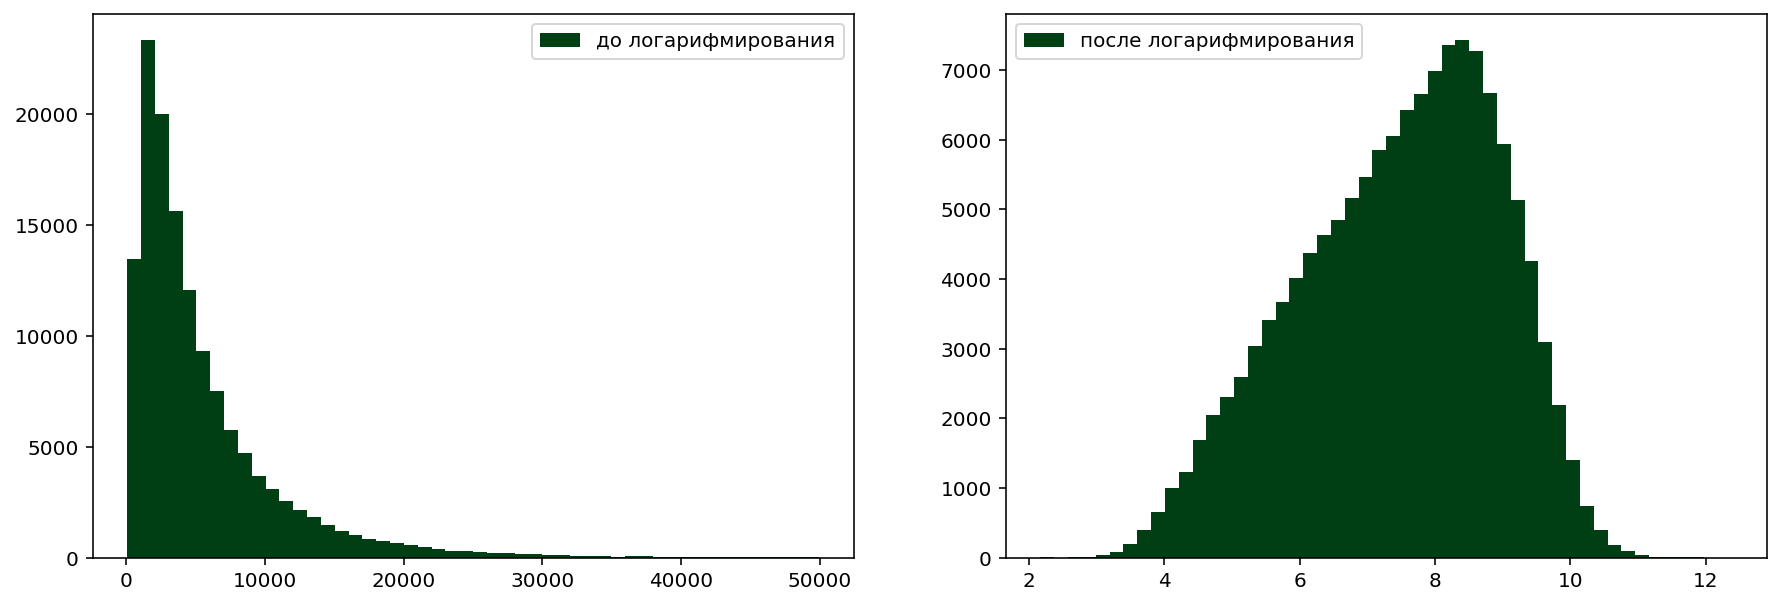

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(rto_n[rto_n <= 50000], bins=50, label='до логарифмирования', color='#003e14')
ax2.hist(rto_n_log, bins=50, label='после логарифмирования', color='#003e14')

ax1.legend(loc='best')
ax2.legend(loc='best')
plt.show()

Как видно, распределение не совсем похоже на нормальное, хотя уже и значительно ближе. Дело в том, что мы применяли формулу `log(1 + x)`, а не просто логарифм, чтобы избежать значений `inf` из-за большого числа нулей в датасете.

Есть вариант с этим бороться: поскольку все признаки так или иначе бывают нулевыми, необходимо создать новые признаки, которые нулевыми точно не будут.

### Разделение на тренировочную и тестовую выборки

In [46]:
# разделение полных неочищенных данных
y = data['is_in_club']
X = data.drop(['is_in_club'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=y)

In [47]:
# разделение полностью логарифмированных данных
# у для всех версий датасетов один и тот же
X_log_all = data_log_all.drop(['is_in_club'], axis=1)
X_train_log_all, X_tes_log_all, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, 
                                                                   shuffle=True, stratify=y)

In [48]:
# разделение данных с логарифмированными столбцами rto
# у для всех версий датасетов один и тот же
X_log_rto = data_log_rto.drop(['is_in_club'], axis=1)
X_train_log_rto, X_tes_log_rto, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, 
                                                                   shuffle=True, stratify=y)

### Масштабирование

Поскольку у нас есть две большие группы признаков - `rto` и `cnt`, будет логично производить масштабирование так, чтобы связи между признаками оставались и чтобы масштаб всех признаков каждой группы был один и тот же. Для этого достаточно обучить скейлер на одном признаке из группы, после чего применить его на всех остальных.

In [49]:
# функция для масштабирования групп столбцов
def scale_data(scaler, data, transform_cols, fit=True) -> np.ndarray:
    """
    :param scaler: sklearn.preprocessing.StandardScaler object
    :param data: pd.DataFrame (dataset to scale)
    :param transform_cols: list of string column names (transforming columns with a fitted scaler)
    :param fit: indicator if the scaler should be fitted
    """
    
    new_data = np.nan
    for col in transform_cols:
        new_col = scaler.transform(data[col].to_numpy().reshape(-1, 1))
        if new_data is np.nan:
            new_data = new_col
        else:
            new_data = np.concatenate((new_data, new_col), axis=1)
    
    return new_data

Будем пробовать разное масштабирование: и с группировкой, и без нее

In [50]:
# определяем масштабируемые колонки
rto_columns = cols['rto_n'] + cols['rto_n_category'] + cols['rto_std_n'] + cols['rto_std_n_category'] + cols['rto_var_n'] + cols['rto_var_n_category']
# масштабируем их с помощью функции
rto_scaler = StandardScaler()
rto_scaler.fit(X_train['rto_6'].to_numpy().reshape(-1, 1))

rto_scaled_train = scale_data(rto_scaler, X_train, rto_columns)
rto_scaled_test = scale_data(rto_scaler, X_test, rto_columns)

# определяем второй список масштабируемых колонок
cnt_columns = cols['cnt_checks_n'] + cols['cnt_checks_n_category']
# скейлим их с помощью функции
cnt_scaler = StandardScaler()
cnt_scaler.fit(X_train['cnt_checks_6'].to_numpy().reshape(-1, 1))

cnt_scaled_train = scale_data(cnt_scaler,  X_train, cnt_columns)
cnt_scaled_test = scale_data(cnt_scaler,  X_test, cnt_columns)

In [51]:
scaled_data_rto = pd.DataFrame(data=rto_scaled_train, columns=rto_columns, index=X_train.index)
scaled_data_cnt = pd.DataFrame(data=cnt_scaled_train, columns=cnt_columns, index=X_train.index)
X_train_scaled = pd.concat([scaled_data_rto, scaled_data_cnt], axis=1)
# X_train_scaled['index'] = X_train.index
# X_train_scaled = X_train_scaled.set_index('index', inplace=True)

scaled_data_rto = pd.DataFrame(data=rto_scaled_test, columns=rto_columns, index=X_test.index)
scaled_data_cnt = pd.DataFrame(data=cnt_scaled_test, columns=cnt_columns, index=X_test.index)
X_test_scaled = pd.concat([scaled_data_rto, scaled_data_cnt], axis=1)
# X_test_scaled['index'] = X_test.index
# X_test_scaled = X_test_scaled.set_index('index', inplace=True)

In [52]:
# масштабируем прологарифмированные данные
rto_log_columns = cols['rto_n'] + cols['rto_n_category']+ cols['rto_var_n'] + cols['rto_var_n_category']
rto_log_scaler = StandardScaler()
rto_log_scaler.fit(X_train_log_rto['rto_6'].to_numpy().reshape(-1, 1))

rto_log_scaled_train = scale_data(rto_log_scaler, X_train_log_rto, rto_log_columns)
rto_log_scaled_test = scale_data(rto_log_scaler, X_tes_log_rto, rto_log_columns)


cnt_log_scaler = StandardScaler()
cnt_log_scaler.fit(X_train_log_rto['cnt_checks_6'].to_numpy().reshape(-1, 1))

cnt_log_scaled_train = scale_data(cnt_log_scaler,  X_train_log_rto, cnt_columns)
cnt_log_scaled_test = scale_data(cnt_log_scaler,  X_tes_log_rto, cnt_columns)

In [53]:
X_train_log_rto_scaled = pd.concat([pd.DataFrame(data=rto_log_scaled_train, columns=rto_log_columns, 
                                                 index=X_train.index), 
                                    pd.DataFrame(data=cnt_log_scaled_train, columns=cnt_columns, 
                                                 index=X_train.index)], axis=1)

X_test_log_rto_scaled = pd.concat([pd.DataFrame(data=rto_log_scaled_test, columns=rto_log_columns, 
                                                index=X_test.index), 
                                    pd.DataFrame(data=cnt_log_scaled_test, columns=cnt_columns, 
                                                 index=X_test.index)], axis=1)

In [54]:
# масштабируем прологарифмированные данные
rto_log_columns = cols['rto_n'] + cols['rto_n_category']+ cols['rto_var_n'] + cols['rto_var_n_category']
rto_log_scaler = StandardScaler()
rto_log_scaler.fit(X_train_log_all['rto_6'].to_numpy().reshape(-1, 1))

rto_log_scaled = scale_data(rto_log_scaler, X_train_log_all, rto_log_columns)


cnt_log_scaler = StandardScaler()
cnt_log_scaler.fit(X_train_log_all['cnt_checks_6'].to_numpy().reshape(-1, 1))

cnt_log_scaled = scale_data(cnt_log_scaler,  X_train_log_all, cnt_columns)

X_train_log_scaled = pd.concat([pd.DataFrame(data=rto_log_scaled, columns=rto_log_columns), 
                                pd.DataFrame(data=cnt_log_scaled, columns=cnt_columns)], axis=1)


# масштабируем прологарифмированные тестовые данные
test_rto_log_scaled = scale_data(rto_log_scaler, X_tes_log_all, rto_log_columns)
test_cnt_log_scaled = scale_data(cnt_log_scaler,  X_tes_log_all, cnt_columns)

X_test_log_scaled = pd.concat([pd.DataFrame(data=test_rto_log_scaled, columns=rto_log_columns, 
                                            index=X_tes_log_all.index), 
                               pd.DataFrame(data=test_cnt_log_scaled, columns=cnt_columns, 
                                            index=X_tes_log_all.index)], axis=1)

## Модели

### 1. Метрики и функции вывода результата

Метрики

In [55]:
scoring = {'f2': make_scorer(fbeta_score, beta=2), 'precision': 'precision', 'recall':'recall'}

In [56]:
f2_score = make_scorer(fbeta_score, beta=2)

Функции вывода результата

In [57]:
# после тренировк и кросс валидации
def print_metrics(scores):
    print(f"Cross-val-scores  Train     Test")
    print(f"F2                {scores['train_f2'].mean()*100:.2f}%      {scores['test_f2'].mean()*100:.2f}%")
    print(f"Precision         {scores['train_precision'].mean()*100:.2f}%     {scores['test_precision'].mean()*100:.2f}%")
    print(f"Recall            {scores['train_recall'].mean()*100:.2f}%      {scores['test_recall'].mean()*100:.2f}%")

In [58]:
# тестирование финальной модели
def test_final(final_model, X_train, y_train, X_test, y_test, threshold=0.45):
    final_model.fit(X_train, y_train)
    train_probas = pd.DataFrame(final_model.predict_proba(X_train))
    test_probas = pd.DataFrame(final_model.predict_proba(X_test))

    train_preds = train_probas.applymap(lambda x: 1 if x > threshold else 0).iloc[:,1]
    test_preds = test_probas.applymap(lambda x: 1 if x > threshold else 0).iloc[:,1]

    print(f"                   Train     Test")
    print(f"F4                {fbeta_score(y_train, train_preds, beta = 4)*100:.2f}%      {fbeta_score(y_test, test_preds, beta = 4)*100:.2f}%")
    print(f"F3                {fbeta_score(y_train, train_preds, beta = 3)*100:.2f}%      {fbeta_score(y_test, test_preds, beta = 3)*100:.2f}%")
    print(f"F2                {fbeta_score(y_train, train_preds, beta = 2)*100:.2f}%      {fbeta_score(y_test, test_preds, beta = 2)*100:.2f}%")
    print(f"Precision         {precision_score(y_train, train_preds)*100:.2f}%      {precision_score(y_test, test_preds)*100:.2f}%")
    print(f"Recall            {recall_score(y_train, train_preds)*100:.2f}%      {recall_score(y_test, test_preds)*100:.2f}%")

### 2. Поиск лучшей модели

#### 2.1 LogReg + SMOTE, без калибровки 

В прошлый раз лучше всего показала себя модель LogisticRegression + SMOTE oversampling. В этот раз возьмем ее же и будем дорабатывать на других признаках.

In [23]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                ['classifier', LogisticRegression(random_state=0, max_iter=10000, C=0.2)]])

In [79]:

pipeline_1 = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                  ['undersampling', RandomUnderSampler(random_state=0)],
                                  ['classifier', LogisticRegression(random_state=0, max_iter=10000, C=1)]])

# columns_to_drop = cols['rto_n'] + cols['rto_n_category'] + cols['rto_var_n'] + cols['rto_var_n_category']
# columns_to_drop = cols['rto_n'] + cols['rto_var_n'] + cols['cnt_checks_n']

# test_final(pipeline_1, X_train_log_rto_scaled.drop(columns=columns_to_drop), y_train, 
#            X_test_log_rto_scaled.drop(columns=columns_to_drop), y_test)

In [29]:
# полные данные
test_final(pipeline, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   Train     Test
F2                41.28%      34.94%
Precision         16.84%      12.76%
Recall            64.79%      61.81%


In [31]:
# полные логарифмированные данные
test_final(pipeline, X_train_log_all, y_train, X_tes_log_all, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   Train     Test
F2                41.28%      34.94%
Precision         16.84%      12.76%
Recall            64.79%      61.81%


In [32]:
# частично логарифмированные данные
test_final(pipeline, X_train_log_rto, y_train, X_tes_log_rto, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   Train     Test
F2                41.28%      34.94%
Precision         16.84%      12.76%
Recall            64.79%      61.81%


In [33]:
# только с дисперсией
test_final(pipeline, X_train.drop(columns=cols['rto_std_n']+cols['rto_std_n_category']), y_train, 
           X_test.drop(columns=cols['rto_std_n']+cols['rto_std_n_category']), y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   Train     Test
F2                39.34%      32.23%
Precision         12.86%      9.48%
Recall            81.07%      80.59%


In [34]:
# только с стд
test_final(pipeline, X_train.drop(columns=cols['rto_var_n']+cols['rto_var_n_category']), y_train, 
           X_test.drop(columns=cols['rto_var_n']+cols['rto_var_n_category']), y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   Train     Test
F2                41.43%      35.38%
Precision         17.40%      13.64%
Recall            63.27%      58.81%


In [35]:
# без дисперсии и стд
columns_to_drop = cols['rto_var_n'] + cols['rto_var_n_category'] + cols['rto_std_n'] + cols['rto_std_n_category']
test_final(pipeline, X_train.drop(columns=columns_to_drop), y_train, 
           X_test.drop(columns=columns_to_drop), y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   Train     Test
F2                42.40%      36.83%
Precision         16.94%      14.04%
Recall            67.91%      61.98%


#### 2.2 LogReg + SMOTE, с калибровкой

Дополнительно добавим к модели калибровку вероятностей.

In [81]:
pipeline_cal = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                    ['classifier', CalibratedClassifierCV(LogisticRegression(random_state=0, max_iter=10000, C=0.2), 
                                                                          method='sigmoid', cv=5)]])

In [82]:
# модель с калибровкой
pipeline_2 = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                  ['undersampling', RandomUnderSampler(random_state=0)],
                                  ['classifier', CalibratedClassifierCV(LogisticRegression(random_state=0, max_iter=10000, C=1),
                                                                        method='sigmoid', cv=3)]])

# columns_to_drop = cols['rto_n'] + cols['rto_n_category'] + cols['rto_var_n'] + cols['rto_var_n_category']
# columns_to_drop = cols['rto_var_n'] + cols['rto_var_n_category']

# test_final(pipeline_2, X_train_log_rto_scaled.drop(columns=columns_to_drop), y_train, 
#            X_test_log_rto_scaled.drop(columns=columns_to_drop), y_test)

In [166]:
pipeline_3 = imbpipeline(steps = [['undersampling', RandomUnderSampler(random_state=0)],
                                  ['smote', SMOTE(random_state=0)],
                                  ['classifier', CalibratedClassifierCV(LogisticRegression(random_state=0, max_iter=10000, C=1),
                                                                        method='sigmoid', cv=3)]])

In [212]:
pipeline_4 = imbpipeline(steps = [['asmo', ADASYN(random_state=0)],
                                  ['undersampling', RandomUnderSampler(random_state=0)],
                                  ['classifier', CalibratedClassifierCV(LogisticRegression(random_state=0, max_iter=10000, C=1),
                                                                        method='sigmoid', cv=3)]])

In [ ]:
# полные данные
test_final(pipeline_cal, X_train, y_train, X_test, y_test)

In [ ]:
# полные логарифмированные данные
test_final(pipeline_cal, X_train_log_all, y_train, X_tes_log_all, y_test)

In [ ]:
# частично логарифмированные данные
test_final(pipeline_cal, X_train_log_rto, y_train, X_tes_log_rto, y_test)

In [ ]:
# только с дисперсией
test_final(pipeline_cal, X_train.drop(columns=cols['rto_std_n']+cols['rto_std_n_category']), y_train, 
           X_test.drop(columns=cols['rto_std_n']+cols['rto_std_n_category']), y_test)

In [ ]:
# только с стд
test_final(pipeline_cal, X_train.drop(columns=cols['rto_var_n']+cols['rto_var_n_category']), y_train, 
           X_test.drop(columns=cols['rto_var_n']+cols['rto_var_n_category']), y_test)

In [ ]:
# без дисперсии и стд
columns_to_drop = cols['rto_var_n'] + cols['rto_var_n_category'] + cols['rto_std_n'] + cols['rto_std_n_category']
test_final(pipeline_cal, X_train.drop(columns=columns_to_drop), y_train, 
           X_test.drop(columns=columns_to_drop), y_test)

#### 2.3 PU Learning

In [29]:
class ElkanotoPuClassifier(BaseEstimator, ClassifierMixin):
    """
    Positive-unlabeled classifier using the unweighted Elkan & Noto method.
    Parameters
    ----------
    estimator : sklearn.BaseEstimator
        Any sklearn-compliant estimator object implementing the fit() and
        predict_proba() methods.
    hold_out_ratio : float, default 0.1
       The ratio of training examples to set aside to estimate the probability
       of an exmaple to be positive.
    """

    def __init__(self, estimator, hold_out_ratio=0.1):
        self.estimator = estimator
        # c is the constant proba that a example is positive, init to 1
        self.c = 1.0
        self.hold_out_ratio = hold_out_ratio

    def fit(self, X, y):
        """Fits the classifier

        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples]
            The target values. An array of int.

        Returns
        -------
        self : object
            Returns self.
        """
        positives = np.where(y == 1.0)[0]
        hold_out_size = int(np.ceil(len(positives) * self.hold_out_ratio))
        # check for the required number of positive examples
        if len(positives) <= hold_out_size:
            raise ValueError(
                'Not enough positive examples to estimate p(s=1|y=1,x).'
                ' Need at least {}.'.format(hold_out_size + 1)
            )
        # construct the holdout set
        np.random.shuffle(positives)
        hold_out = positives[:hold_out_size]
        X_hold_out = X[hold_out]
        X = np.delete(X, hold_out, 0)
        y = y[set(y.index) - set(hold_out)]
        # fit the inner estimator
        self.estimator.fit(X, y)
        # update c, the positive proba estimate
        self.c = np.mean(self.estimator.predict_proba(X_hold_out)[:, 1])

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)[:, 1] / self.c

    def predict(self, X, threshold=0.5):
        return np.array([1.0 if p > threshold else 0 for p in self.predict_proba(X)])

In [30]:
over = SMOTE(random_state=42, sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('under', under)]
os = imbpipeline(steps=steps)

pu_estimator = ElkanotoPuClassifier(estimator=CalibratedClassifierCV(LogisticRegression(max_iter=10000, 
                                                                                        penalty='l2', 
                                                                                        random_state=42, C=1), 
                                                                     cv=7, method='sigmoid'), hold_out_ratio=0.07)

### Отбор признаков

#### Добавление новых признаков

У нас есть разбиение по месяцам. Что будет если убрать его и заменить средними?

In [66]:
def mean_month_columns(X, cols, replace=True, inplace=False):
    if not inplace:
        X_newcols = X.copy()
    else:
        X_newcols = X
    for column in list(cols.keys()):
        try:
            a = X_newcols[cols[column]].values[0]
            key = 1
        except:
            key = 0
        if '_n' in column and key == 1:
            # если есть разбиение по категориям
            if '_category' in  column:
                # вытаскиваем имя колонки, чтобы потом вставить туда новую категорию
                name_temp = column.split('_category')[0]
                name_temp = name_temp.replace('std', 'stddev')
                for cat in categories:
                    name = f'{name_temp}_{cat}'
                    parts = name.split('_n')
                    
                    # колонки по одной категории, но по разным месяцам
                    cat_n_cols = [f'{parts[0]}_{i}{parts[1]}' for i in range(6, 13)]
                    # берем по ним среднее и создаем новый столбец данных
                    X_newcols[name] = X_newcols[cat_n_cols].mean(axis=1)
            # если нет разбиения по категориям
            else:
                # создаем новую колонку со средним
                X_newcols[column] = X_newcols[cols[column]].mean(axis=1)

            if replace:
                # удаляем старые столбцы
                X_newcols = X_newcols.drop(columns=cols[column])
    
    return X_newcols

In [67]:
X_train_newcols = mean_month_columns(X_train_scaled, cols)
X_test_newcols = mean_month_columns(X_test_scaled, cols)

In [85]:
X_train_newcols.describe()

,rto_n,rto_n_Рыба и рыбные изделия,rto_n_Птица и изделия из птицы,rto_n_Сыры,rto_n_Крупы и зерновые,rto_n_Овощи - Фрукты,rto_n_Мясная гастрономия,rto_std_n,rto_stddev_n_Рыба и рыбные изделия,rto_stddev_n_Птица и изделия из птицы,...,cnt_checks_n_Крупы и зерновые,cnt_checks_n_Овощи - Фрукты,cnt_checks_n_Мясная гастрономия,rto_var_n,rto_var_n_Рыба и рыбные изделия,rto_var_n_Птица и изделия из птицы,rto_var_n_Сыры,rto_var_n_Крупы и зерновые,rto_var_n_Овощи - Фрукты,rto_var_n_Мясная гастрономия
count,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000,...,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000,94542.000000
mean,0.099392,-0.807933,-0.782975,-0.773472,-0.811089,-0.721757,-0.767148,-0.737658,-0.816703,-0.814934,...,-0.872772,-0.542189,-0.756714,95.996129,-0.261477,-0.397816,-0.305038,-0.778117,-0.297100,-0.282522
std,0.937345,0.029862,0.055235,0.060000,0.011688,0.127245,0.073703,0.059720,0.004523,0.004555,...,0.070807,0.375838,0.199050,238.688032,11.663413,2.530287,2.811681,0.255983,2.394092,3.190739
min,-0.807176,-0.817575,-0.817575,-0.817575,-0.817575,-0.817575,-0.817575,-0.816551,-0.817601,-0.817646,...,-0.917363,-0.917363,-0.917363,-0.803633,-0.817575,-0.817575,-0.817575,-0.817575,-0.817575,-0.817575
25%,-0.490787,-0.817575,-0.814430,-0.809515,-0.817575,-0.794874,-0.810311,-0.777360,-0.817575,-0.817575,...,-0.917363,-0.786231,-0.879897,15.881452,-0.817575,-0.817575,-0.817575,-0.817575,-0.714025,-0.817575
50%,-0.194587,-0.817575,-0.802022,-0.792928,-0.815098,-0.761404,-0.792368,-0.752064,-0.817575,-0.817174,...,-0.898630,-0.655099,-0.823698,40.957697,-0.817575,-0.810638,-0.719957,-0.817575,-0.547604,-0.712942
75%,0.354075,-0.814044,-0.773975,-0.760617,-0.809660,-0.694865,-0.753720,-0.715638,-0.817575,-0.813877,...,-0.861164,-0.430301,-0.711299,97.096076,-0.817575,-0.509867,-0.415838,-0.809028,-0.259379,-0.301164
max,18.848148,0.096835,1.130049,1.332986,-0.217387,7.869581,2.339736,0.291923,-0.528480,-0.635984,...,2.042477,5.414447,2.192342,14287.752664,3271.390064,322.980235,312.890456,27.498780,528.045588,814.673653


Теперь обучим модель на новых данных

In [86]:
pipeline_newcols = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                        ['undersampling', RandomUnderSampler(random_state=0)],
                                        ['classifier', LogisticRegression(random_state=0, max_iter=5000, C=1)]])

In [67]:
test_final(pipeline_2, X_train_newcols, y_train, X_test_newcols, y_test)

                   Train     Test
F2                42.22%      36.30%
Precision         16.99%      14.87%
Recall            67.13%      56.74%


In [68]:
test_final(pipeline_newcols, X_train_newcols, y_train, X_test_newcols, y_test)

                   Train     Test
F2                42.04%      35.64%
Precision         16.78%      14.60%
Recall            67.40%      55.70%


Посмотрим, что будет, если оставить только stddev или только var

In [33]:
stdcols_to_drop = []
varcols_to_drop = []
for col in X_train_newcols.columns:
    if '_std' in col:
        stdcols_to_drop.append(col)
    elif '_var' in col:
        varcols_to_drop.append(col)

In [70]:
# без стд столбцов
# результат лучше, чем с ними
test_final(pipeline_2, X_train_newcols.drop(columns=stdcols_to_drop), y_train, 
           X_test_newcols.drop(columns=stdcols_to_drop), y_test)

                   Train     Test
F2                42.47%      36.34%
Precision         17.45%      15.05%
Recall            66.22%      56.22%


In [71]:
# без вар столбцов
# результат хуже, чем с ними
test_final(pipeline_2, X_train_newcols.drop(columns=varcols_to_drop), y_train, 
           X_test_newcols.drop(columns=varcols_to_drop), y_test)

                   Train     Test
F2                42.17%      35.74%
Precision         16.82%      14.53%
Recall            67.67%      56.29%


**Вывод:** лучше убрать столбцы со стандартным отклонением, чем с дисперсией.

Попробуем к датасету без стд добавить столбцы rto_n

In [81]:
# без стд столбцов
# со столбцами rto_n
# с ними работает лучше, чем без них
test_final(pipeline_2, pd.concat([X_train_newcols.drop(columns=stdcols_to_drop), X_train_scaled[cols['rto_n']]], axis=1), y_train, 
           pd.concat([X_test_newcols.drop(columns=stdcols_to_drop), X_test_scaled[cols['rto_n']]], axis=1), y_test)

                   Train     Test
F2                43.25%      37.33%
Precision         17.98%      15.25%
Recall            66.69%      58.50%


**Попробуем сделать то же самое с обычными данными, а потом отскейлим обычным методом**

In [34]:
X_train_usuallyscaled = mean_month_columns(X_train, cols)
X_test_usuallyscaled = mean_month_columns(X_test, cols)

In [35]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train_usuallyscaled)
test_scaled = scaler.transform(X_test_usuallyscaled)

X_train_usuallyscaled = pd.DataFrame(train_scaled, index=X_train_usuallyscaled.index, 
                                     columns=X_train_usuallyscaled.columns)

X_test_usuallyscaled = pd.DataFrame(test_scaled, index=X_test_usuallyscaled.index, 
                                     columns=X_test_usuallyscaled.columns)

In [74]:
test_final(pipeline_2, X_train_usuallyscaled, y_train, X_test_usuallyscaled, y_test)

                   Train     Test
F2                42.46%      36.39%
Precision         16.80%      14.73%
Recall            68.69%      57.53%


In [80]:
# без стд столбцов 
# работает еще получше
test_final(pipeline_2, X_train_usuallyscaled.drop(columns=stdcols_to_drop), y_train, 
           X_test_usuallyscaled.drop(columns=stdcols_to_drop), y_test)

                   Train     Test
F2                42.46%      36.52%
Precision         17.44%      15.14%
Recall            66.20%      56.43%


#### Добавление новых данных

Теперь добавим столбцы, добавленные в финале

In [60]:
add_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cup_it_additional_data.csv', index_col='index').drop(columns='Unnamed: 0')

In [61]:
add_cols = {
    'cnt_unique_plu_n': [f'cnt_unique_plu_{n}' for n in range(6, 13)],
    'cnt_unique_plu_n_category': [f'cnt_unique_plu_{n}_{cat}' for n in range(6, 13) for cat in categories]
}

Поделим на тренировочную и тестовую выборку. У нас фиксрованный random state, так что можно быть уверенными, что данные будут мэтчиться

In [62]:
# сначала заполним пустые значения в соответствии с рекомендациями
add_data = add_data.fillna(0)

In [63]:
X_add_train, X_add_test, _, _ = train_test_split(add_data, y, test_size=0.3, random_state=42, 
                                                 shuffle=True, stratify=y)

Отмасштабируем их, тк на неотмастабированных данных вряд ли будет хорошо работать

In [64]:
scaler = StandardScaler()
train = scaler.fit_transform(X_add_train)
test = scaler.transform(X_add_test)

X_add_train = pd.DataFrame(train, index=X_add_train.index, 
                           columns=X_add_train.columns)
X_add_test = pd.DataFrame(test, index=X_add_test.index,
                          columns=X_add_test.columns)

Добавим их к лучшей модели с сокращенными данными

In [165]:
# без стд столбцов
# со столбцами rto_n
# с новыми данными, полными
train = pd.concat([X_train_newcols.drop(columns=stdcols_to_drop), 
                   X_train_scaled[cols['rto_n']], 
                   X_add_train], axis=1).drop(columns=['rto_n'])
test = pd.concat([X_test_newcols.drop(columns=stdcols_to_drop), 
                  X_test_scaled[cols['rto_n']],
                  X_add_test], axis=1).drop(columns=['rto_n'])

test_final(pipeline_2, train, y_train, test, y_test)

                   Train     Test
F4                58.05%      58.60%
F3                52.27%      52.77%
F2                42.09%      42.50%
Precision         16.46%      16.62%
Recall            68.93%      69.58%


Посмотрим, что будет, если поменять оверсемплинг и андерсемплинг местами

In [167]:
test_final(pipeline_3, train, y_train, test, y_test)

                   Train     Test
F4                57.82%      58.36%
F3                52.28%      52.77%
F2                42.42%      42.82%
Precision         16.91%      17.07%
Recall            68.11%      68.75%


Теперь сократим новые данные

In [96]:
X_train_add_newcols = mean_month_columns(X_add_train, add_cols)
X_test_add_newcols = mean_month_columns(X_add_test, add_cols)

In [97]:
train = pd.concat([X_train_newcols.drop(columns=stdcols_to_drop), 
                   X_train_scaled[cols['rto_n']], 
                   X_train_add_newcols], axis=1).drop(columns=['rto_n'])
test = pd.concat([X_test_newcols.drop(columns=stdcols_to_drop), 
                  X_test_scaled[cols['rto_n']],
                  X_test_add_newcols.reset_index().drop(columns=['index'])], axis=1).drop(columns=['rto_n'])

test_final(pipeline_2, train, y_train, test, y_test)

                   Train     Test
F4                57.85%      52.05%
F3                52.60%      47.06%
F2                43.10%      38.16%
Precision         17.63%      15.19%
Recall            67.48%      61.36%


#### С помощью параметров модели

Сначала обучим логистическую регрессию на всех данных. 

Важно то, что данные обязательно должны быть отмастабированы, тк на неотмасштабированных данных параметры модели будут тоже разного масштаба и оценить по ним важность признаков будет нельзя.

In [60]:
# логистическая регрессия, без оверсемплинга, на всех отмасштабированных данных
start = time.time()

clf = LogisticRegression(random_state=0, max_iter=5000, C=1)
test_final(clf, X_train_scaled, y_train, X_test_scaled, y_test)

end = time.time()
print(f'Execution time: {end - start} sec')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   Train     Test
F2                3.83%      2.84%
Precision         43.55%      32.68%
Recall            3.12%      2.31%


In [64]:
ws = clf.coef_
coefs = pd.DataFrame(list(zip(X_train_scaled.columns, ws[0])), columns=['Features', 'Coefficient']).set_index('Features')
new_cols = abs(coefs['Coefficient']).nlargest(40).reset_index()['Features'].values

In [70]:
pipeline_2 = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                  ['undersampling', RandomUnderSampler(random_state=0)],
                                  ['classifier', CalibratedClassifierCV(LogisticRegression(random_state=0, max_iter=5000, C=1),
                                                                        method='sigmoid', cv=3)]])


test_final(pipeline_2, X_train_scaled[new_cols], y_train, 
           X_test_scaled[new_cols], y_test)

                   Train     Test
F2                38.74%      33.99%
Precision         19.33%      17.08%
Recall            51.71%      45.16%


Теперь попробуем на отлогарифмированном датасете (только rto)

In [68]:
# бейзлайн модель, без оверсемплинга, log(rto)
start = time.time()

clf = LogisticRegression(random_state=0, max_iter=5000, C=1)
test_final(clf, X_train_log_rto_scaled, y_train, X_test_log_rto_scaled, y_test)

end = time.time()
print(f'Execution time: {end - start} sec')

                   Train     Test
F2                3.66%      2.50%
Precision         40.69%      29.35%
Recall            2.98%      2.03%
Execution time: 193.9269630908966 sec


In [71]:
ws = clf.coef_
coefs = pd.DataFrame(list(zip(X_train_scaled.columns, ws[0])), columns=['Features', 'Coefficient']).set_index('Features')
new_cols = abs(coefs['Coefficient']).nlargest(40).reset_index()['Features'].values

test_final(pipeline_2, X_train_log_rto_scaled[new_cols], y_train, 
           X_test_log_rto_scaled[new_cols], y_test)

                   Train     Test
F2                38.74%      33.99%
Precision         19.33%      17.08%
Recall            51.71%      45.16%


Но у нас простая логистическая регрессия дает плохой результат, поэтому будем делать оверсемплинг и андерсемплинг, чтобы получать коэффициенты с их учетом.

In [31]:
# бейзлайн модель, с овер(андер)семплингом, log(rto)
start = time.time()

clf = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                           ['undersampling', RandomUnderSampler(random_state=0)],
                           ['classifier', LogisticRegression(random_state=0, max_iter=5000, C=1)]])
test_final(clf, X_train_log_rto_scaled, y_train, X_test_log_rto_scaled, y_test)

end = time.time()
print(f'Execution time: {end - start} sec')

                   Train     Test
F4                56.34%      56.35%
F3                51.40%      51.41%
F2                42.37%      42.39%
Precision         17.61%      17.63%
Recall            65.32%      65.32%
Execution time: 318.20716309547424 sec


In [97]:
# бейзлайн модель, с овер(андер)семплингом, масштабированные данные
ws = clf.named_steps['classifier'].coef_
coefs = pd.DataFrame(list(zip(X_train_scaled.columns, ws[0])), columns=['Features', 'Coefficient']).set_index('Features')
new_cols = abs(coefs['Coefficient']).nlargest(35).reset_index()['Features'].values

test_final(pipeline_2, X_train_log_rto_scaled[new_cols], y_train, 
           X_test_log_rto_scaled[new_cols], y_test)

                   Train     Test
F2                40.52%      34.72%
Precision         16.06%      13.39%
Recall            65.44%      57.70%


#### С помощью статистического параметра

Попробуем отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

In [93]:
sigma_plus = X_train[y_train == 1].std().values
sigma_minus = X_train[y_train == 0].std().values
mu_plus = X_train[y_train == 1].mean().values
mu_minus = X_train[y_train == 0].mean().values

n_plus = np.count_nonzero(y_train == 0)
n_minus = y_train.shape[0] - n_plus

f = abs(mu_plus - mu_minus) / np.sqrt((n_plus * sigma_plus + n_minus * sigma_minus) / (n_plus + n_minus))

ind = np.sort(np.argpartition(f, -40)[-40:])
selected_cols = X_train.columns[ind]

In [94]:
test_final(pipeline_2, X_train_log_rto_scaled[selected_cols], y_train, 
           X_test_log_rto_scaled[selected_cols], y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   Train     Test
F2                41.81%      35.75%
Precision         17.59%      14.96%
Recall            63.76%      54.77%


Посмотрим теперь на тот же индекс, только для обработанного датасета

In [84]:
sigma_plus = X_train_log_rto_scaled[y_train == 1].std().values
sigma_minus = X_train_log_rto_scaled[y_train == 0].std().values
mu_plus = X_train_log_rto_scaled[y_train == 1].mean().values
mu_minus = X_train_log_rto_scaled[y_train == 0].mean().values

n_plus = np.count_nonzero(y_train == 0)
n_minus = y_train.shape[0] - n_plus

f = abs(mu_plus - mu_minus) / np.sqrt((n_plus * sigma_plus + n_minus * sigma_minus) / (n_plus + n_minus))

ind = np.sort(np.argpartition(f, -40)[-40:])
selected_cols_log_scaled = X_train_log_rto_scaled.columns[ind]

In [91]:
test_final(pipeline_2, X_train_log_rto_scaled[selected_cols_log_scaled], y_train, 
           X_test_log_rto_scaled[selected_cols_log_scaled], y_test)

                   Train     Test
F2                43.20%      37.26%
Precision         18.39%      15.52%
Recall            65.19%      57.36%


In [99]:
test_final(pipeline_1, X_train_log_rto_scaled[selected_cols_log_scaled], y_train, 
           X_test_log_rto_scaled[selected_cols_log_scaled], y_test)

                   Train     Test
F2                43.03%      37.05%
Precision         18.42%      15.64%
Recall            64.61%      56.33%


А теперь посмотрим, какие признаки отберет статистический параметр после добавления новых признаков

In [235]:
train_all = mean_month_columns(X_train_log_rto_scaled, cols, replace=False)
test_all = mean_month_columns(X_test_log_rto_scaled, cols, replace=False)

train_new = mean_month_columns(X_add_train, add_cols, replace=False)
test_new = mean_month_columns(X_add_test, add_cols, replace=False)

train = pd.concat([train_all, train_new], axis=1)
test = pd.concat([test_all, test_new], axis=1)

In [70]:
sigma_plus = train[y_train == 1].std().values
sigma_minus = train[y_train == 0].std().values
mu_plus = train[y_train == 1].mean().values
mu_minus = train[y_train == 0].mean().values

n_plus = np.count_nonzero(y_train == 0)
n_minus = y_train.shape[0] - n_plus

f = abs(mu_plus - mu_minus) / np.sqrt((n_plus * sigma_plus + n_minus * sigma_minus) / (n_plus + n_minus))

ind = np.sort(np.argpartition(f, -105)[-105:])
our_columns = train.columns[ind]

In [198]:
# если брать 105 признаков
test_final(pipeline_2, train[our_columns], y_train, 
           test[our_columns], y_test)

                   Train     Test
F4                57.45%      57.24%
F3                52.28%      52.07%
F2                42.89%      42.71%
Precision         17.61%      17.52%
Recall            66.92%      66.68%


In [199]:
# если брать 105 признаков
test_final(pipeline_3, train[our_columns], y_train, 
           test[our_columns], y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   Train     Test
F4                58.00%      58.19%
F3                52.48%      52.68%
F2                42.64%      42.82%
Precision         17.05%      17.15%
Recall            68.25%      68.43%


In [213]:
# если брать 105 признаков
test_final(pipeline_4, train[our_columns], y_train, 
           test[our_columns], y_test)

                   Train     Test
F4                58.11%      57.37%
F3                52.73%      52.04%
F2                43.06%      42.46%
Precision         17.45%      17.18%
Recall            68.01%      67.19%


А теперь посмотрим, можно ли эти данные логарифмировать

In [200]:
train_log = train[our_columns].copy().apply(lambda x: np.log1p(x + 1))
test_log = test[our_columns].copy().apply(lambda x: np.log1p(x + 1))

In [201]:
# если брать 105 признаков
test_final(pipeline_2, train_log, y_train, 
           test_log, y_test)

                   Train     Test
F4                60.19%      59.71%
F3                53.68%      53.26%
F2                42.51%      42.20%
Precision         15.95%      15.86%
Recall            72.82%      72.19%


Обучим другую модель (PU Learning) на отобранных признаках

In [267]:
X_train_os, y_train_os = os.fit_resample(train[our_columns], y_train)

pu_estimator.fit(X_train_os.reset_index(drop=True).values, 
                 y_train_os.reset_index(drop=True))

In [268]:
train_preds = pu_estimator.predict(train[our_columns].values)
test_preds = pu_estimator.predict(test[our_columns].values)

print(f"                   Train     Test")
print(f"F4                {fbeta_score(y_train, train_preds, beta = 4)*100:.2f}%      {fbeta_score(y_test, test_preds, beta = 4)*100:.2f}%")
print(f"F3                {fbeta_score(y_train, train_preds, beta = 3)*100:.2f}%      {fbeta_score(y_test, test_preds, beta = 3)*100:.2f}%")
print(f"F2                {fbeta_score(y_train, train_preds, beta = 2)*100:.2f}%      {fbeta_score(y_test, test_preds, beta = 2)*100:.2f}%")
print(f"Precision         {precision_score(y_train, train_preds)*100:.2f}%      {precision_score(y_test, test_preds)*100:.2f}%")
print(f"Recall            {recall_score(y_train, train_preds)*100:.2f}%      {recall_score(y_test, test_preds)*100:.2f}%")

                   Train     Test
F4                64.00%      63.90%
F3                51.45%      51.38%
F2                34.86%      34.81%
Precision         9.74%      9.73%
Recall            98.19%      98.01%


Поскольку PU Learning представляет из себя кардинально новую модель, порог подберем отдельно

In [292]:
pred_proba_df = pd.DataFrame(pu_estimator.predict_proba(test[our_columns].values))
threshold_list = np.arange(0, 1, 0.01)
threshold_scores = dict.fromkeys(threshold_list)
for threshold in tqdm(threshold_list, leave=False):
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x > threshold else 0)
    test_score = fbeta_score(y_test, Y_test_pred, beta= 2)
    threshold_scores[threshold] = test_score

print(f"Наибольшее значение f-меры ({max(threshold_scores.values())*100:.2f}%) получается при пороге {max(threshold_scores, key=threshold_scores.get)}")

  0%|          | 0/100 [00:00<?, ?it/s]

Наибольшее значение f-меры (42.84%) получается при пороге 0.77


Посчитаем данные для матрицы ошибок

In [293]:
Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x > 0.77 else 0)

tn, fp, fn, tp = confusion_matrix(y_test, Y_test_pred).ravel()

In [294]:
tn, fp, fn, tp

(23700, 13094, 1102, 2623)

#### Жадный алгоритм

Будем отбирать признаки жадным способом: добавлять по одному, пока не наберется 40 штук

In [101]:
X_train_log_rto_scaled.shape

(94542, 147)

In [112]:
train = X_train_log_rto_scaled[:75000]
val = X_train_log_rto_scaled[75000:]

In [116]:
# сюда будем записывать лучшие результаты
f2_best = [0]
# признаки, которые мы проверяем
features_to_check = train.columns
# признаки, которые отбираем, тк они показали лучший результат
included = []
for i in tqdm(range(40)):
    # запишем результаты всех моделей с этим числом признаков
    f_scores = []
    for include in tqdm(features_to_check, leave=False):
        
        # модель
        pipeline_greedy = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                               ['undersampling', RandomUnderSampler(random_state=0)],
                                               ['classifier', LogisticRegression(random_state=0, max_iter=5000, C=1)]])

        pipeline_greedy.fit(train[[include] + included], y_train[:75000].ravel())
        y_proba_greedy = pd.DataFrame(pipeline_greedy.predict_proba(val[[include] + included]))
        y_preds_greedy = y_proba_greedy.applymap(lambda x: 1 if x > 0.45 else 0).iloc[:,1]
        
        # считаем f2 скор
        f2 = fbeta_score(y_train[75000:], y_preds_greedy, beta = 2)
        # добавляем его в список скоров
        f_scores.append(f2)
    
    f_scores = np.array(f_scores)
    # условие проверки величины приращения качества
    # если все модели стали только хуже, то прекращаем работу
    if np.max(f_scores - f2_best[-1]) <= 0:
        print('Negative growth - loop broken')
        break
    else:
        # если модель с добавлением признака стала лучше, добавляем его скор
        f2_best.append(np.max(f_scores))
        ind = np.argmax(f_scores)
        print(f'features_to_check: "{features_to_check[ind]}" is added')
        # добавляем сам признак
        included.append(features_to_check[ind])
        # иключаем его из списка проверяемых, ведь он уже добавлен
        features_to_check = np.delete(features_to_check, ind)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

features_to_check: "cnt_checks_11_Овощи - Фрукты" is added


  0%|          | 0/146 [00:00<?, ?it/s]

features_to_check: "cnt_checks_12_Овощи - Фрукты" is added


  0%|          | 0/145 [00:00<?, ?it/s]

features_to_check: "rto_11_Сыры" is added


  0%|          | 0/144 [00:00<?, ?it/s]

features_to_check: "cnt_checks_10_Сыры" is added


  0%|          | 0/143 [00:00<?, ?it/s]

features_to_check: "rto_var_12_Птица и изделия из птицы" is added


  0%|          | 0/142 [00:00<?, ?it/s]

features_to_check: "rto_7_Мясная гастрономия" is added


  0%|          | 0/141 [00:00<?, ?it/s]

features_to_check: "cnt_checks_6" is added


  0%|          | 0/140 [00:00<?, ?it/s]

features_to_check: "rto_var_10_Крупы и зерновые" is added


  0%|          | 0/139 [00:00<?, ?it/s]

features_to_check: "rto_var_11_Птица и изделия из птицы" is added


  0%|          | 0/138 [00:00<?, ?it/s]

features_to_check: "rto_6_Крупы и зерновые" is added


  0%|          | 0/137 [00:00<?, ?it/s]

Negative growth - loop broken


In [ ]:
test_final(pipeline_2, X_train_log_rto_scaled[included[:-2]], y_train, 
           X_test_log_rto_scaled[included[:-2]], y_test)

А теперь посмотрим то же самое, но еще и на сгенерированных и на новых признаках

In [153]:
train_all = mean_month_columns(X_train_scaled, cols, replace=False)
test_all = mean_month_columns(X_test_scaled, cols, replace=False)

train_new = mean_month_columns(X_add_train, add_cols, replace=False)
test_new = mean_month_columns(X_add_test, add_cols, replace=False)

train = pd.concat([train_all, train_new], axis=1)
test = pd.concat([test_all, test_new.reset_index().drop(columns=['index'])], axis=1)

In [154]:
train, val, y_tr, y_val = train_test_split(train, y_train, shuffle=False, test_size=0.3)

In [155]:
# сюда будем записывать лучшие результаты
f2_best = [0]
# признаки, которые мы проверяем
features_to_check = train.columns
# признаки, которые отбираем, тк они показали лучший результат
included = []
for i in tqdm(range(40)):
    # запишем результаты всех моделей с этим числом признаков
    f_scores = []
    for include in tqdm(features_to_check, leave=False):
        
        # модель
        pipeline_greedy = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                               ['undersampling', RandomUnderSampler(random_state=0)],
                                               ['classifier', LogisticRegression(random_state=0, max_iter=5000, C=1)]])

        pipeline_greedy.fit(train[[include] + included], y_tr.ravel())
        y_proba_greedy = pd.DataFrame(pipeline_greedy.predict_proba(val[[include] + included]))
        y_preds_greedy = y_proba_greedy.applymap(lambda x: 1 if x > 0.45 else 0).iloc[:,1]
        
        # считаем f2 скор
        f2 = fbeta_score(y_val, y_preds_greedy, beta = 2)
        # добавляем его в список скоров
        f_scores.append(f2)
    
    f_scores = np.array(f_scores)
    # условие проверки величины приращения качества
    # если все модели стали только хуже, то прекращаем работу
    if np.max(f_scores - f2_best[-1]) <= 0:
        print('Negative growth - loop broken')
        break
    else:
        # если модель с добавлением признака стала лучше, добавляем его скор
        f2_best.append(np.max(f_scores))
        ind = np.argmax(f_scores)
        print(f'features_to_check: "{features_to_check[ind]}" is added')
        # добавляем сам признак
        included.append(features_to_check[ind])
        # иключаем его из списка проверяемых, ведь он уже добавлен
        features_to_check = np.delete(features_to_check, ind)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

features_to_check: "cnt_unique_plu_12" is added


  0%|          | 0/279 [00:00<?, ?it/s]

features_to_check: "cnt_checks_11_Овощи - Фрукты" is added


  0%|          | 0/278 [00:00<?, ?it/s]

features_to_check: "rto_var_n_Птица и изделия из птицы" is added


  0%|          | 0/277 [00:00<?, ?it/s]

features_to_check: "cnt_unique_plu_7_Сыры" is added


  0%|          | 0/276 [00:00<?, ?it/s]

features_to_check: "cnt_unique_plu_8_Мясная гастрономия" is added


  0%|          | 0/275 [00:00<?, ?it/s]

features_to_check: "rto_stddev_10_Птица и изделия из птицы" is added


  0%|          | 0/274 [00:00<?, ?it/s]

features_to_check: "rto_var_7_Сыры" is added


  0%|          | 0/273 [00:00<?, ?it/s]

features_to_check: "rto_var_12_Крупы и зерновые" is added


  0%|          | 0/272 [00:00<?, ?it/s]

features_to_check: "rto_stddev_6_Птица и изделия из птицы" is added


  0%|          | 0/271 [00:00<?, ?it/s]

features_to_check: "rto_stddev_7_Крупы и зерновые" is added


  0%|          | 0/270 [00:00<?, ?it/s]

features_to_check: "rto_stddev_8_Мясная гастрономия" is added


  0%|          | 0/269 [00:00<?, ?it/s]

features_to_check: "rto_stddev_8_Крупы и зерновые" is added


  0%|          | 0/268 [00:00<?, ?it/s]

Negative growth - loop broken


Посмотрим на лучше результаты для каждого этапа отбора:

In [156]:
f2_best

[0,
 0.3570030752026839,
 0.36921296296296297,
 0.3730909935543813,
 0.37516170763260026,
 0.3782808589885352,
 0.38078312550984733,
 0.38188380486668994,
 0.3827318836355156,
 0.38289075238760767,
 0.38309153411408264,
 0.3832712022367195,
 0.38329352828100427]

Протестируем на тестовом датасете

In [163]:
train = pd.concat([train_all, train_new], axis=1)

test_final(pipeline_1, train[included], y_train, 
           test[included], y_test)

                   Train     Test
F2                43.14%      36.99%
Precision         17.50%      14.81%
Recall            68.07%      59.12%


### Подбор порога для лучшей модели

Лучшие результаты показали две модели: `pipline_2` и `pu_estimator`. Подберем для них пороги:

In [210]:
final_model = pipeline_2

train_all = mean_month_columns(X_train_log_rto_scaled, cols, replace=False)
test_all = mean_month_columns(X_test_log_rto_scaled, cols, replace=False)

train_new = mean_month_columns(X_add_train, add_cols, replace=False)
test_new = mean_month_columns(X_add_test, add_cols, replace=False)

final_train = pd.concat([train_all, train_new], axis=1)[our_columns]
final_test = pd.concat([test_all, test_new], axis=1)[our_columns]

In [211]:
final_model.fit(final_train, y_train)

pred_proba_df = pd.DataFrame(final_model.predict_proba(final_test))
threshold_list = np.arange(0, 1, 0.01)
threshold_scores = dict.fromkeys(threshold_list)
for threshold in tqdm(threshold_list, leave=False):
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x > threshold else 0)
    test_score = fbeta_score(y_test, Y_test_pred.iloc[:,1], beta= 2)
    threshold_scores[threshold] = test_score

print(f"Наибольшее значение f-меры ({max(threshold_scores.values())*100:.2f}%) получается при пороге {max(threshold_scores, key=threshold_scores.get)}")

  0%|          | 0/100 [00:00<?, ?it/s]

Наибольшее значение f-меры (42.85%) получается при пороге 0.41000000000000003


Для модели `pu_estimator` подбор порога осуществляется в разделе **Отбор признаков: с помощью статистического параметра**

### Бейзлайн модель

In [59]:
final_model = imbpipeline(steps = [['smote', SMOTE(random_state=0)],
                                ['classifier', LogisticRegression(solver = 'lbfgs', 
                                                                  random_state=0, C=1, max_iter=500)]])

final_model.fit(X_train_log_scaled, y_train)

train_preds = final_model.predict(X_train_log_scaled)
test_preds = final_model.predict(X_test_log_scaled)

print(f"                   Train     Test")
print(f"F2                {fbeta_score(y_train, train_preds, beta = 2)*100:.2f}%      {fbeta_score(y_test, test_preds, beta = 2)*100:.2f}%")
print(f"Precision         {precision_score(y_train, train_preds)*100:.2f}%      {precision_score(y_test, test_preds)*100:.2f}%")
print(f"Recall            {recall_score(y_train, train_preds)*100:.2f}%      {recall_score(y_test, test_preds)*100:.2f}%")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


                   Train     Test
F2                40.05%      39.87%
Precision         18.47%      18.43%
Recall            56.57%      56.21%


Данные для матрицы ошибок бейзлайн модели

In [288]:
pred_proba_df = pd.DataFrame(final_model.predict_proba(X_test_log_scaled))
Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x > 0.77 else 0)

tn, fp, fn, tp = confusion_matrix(y_test, Y_test_pred.iloc[:,1]).ravel()

In [289]:
tn, fp, fn, tp

(34852, 1942, 3076, 649)

## Финальное обучение и сохранение данных

In [68]:
train_all = mean_month_columns(X_train_log_rto_scaled, cols, replace=False)
test_all = mean_month_columns(X_test_log_rto_scaled, cols, replace=False)

train_new = mean_month_columns(X_add_train, add_cols, replace=False)
test_new = mean_month_columns(X_add_test, add_cols, replace=False)

train = pd.concat([train_all, train_new], axis=1)
test = pd.concat([test_all, test_new], axis=1)

In [71]:
X_train_os, y_train_os = os.fit_resample(train[our_columns], y_train)

pu_estimator.fit(X_train_os.reset_index(drop=True).values, 
                 y_train_os.reset_index(drop=True))

In [80]:
train_preds = pu_estimator.predict(train[our_columns].values)
test_proba = pu_estimator.predict_proba(test[our_columns].values)

pred_proba_df = pd.DataFrame(test_proba, index=X_test.index)
test_preds = pred_proba_df.applymap(lambda x: 1 if x > 0.77 else 0)


print(f"                   Train     Test")
print(f"F2                {fbeta_score(y_train, train_preds, beta = 2)*100:.2f}%      {fbeta_score(y_test, test_preds, beta = 2)*100:.2f}%")
print(f"Precision         {precision_score(y_train, train_preds)*100:.2f}%      {precision_score(y_test, test_preds)*100:.2f}%")
print(f"Recall            {recall_score(y_train, train_preds)*100:.2f}%      {recall_score(y_test, test_preds)*100:.2f}%")

                   Train     Test
F2                35.35%      42.82%
Precision         9.96%      16.44%
Recall            97.53%      71.52%


In [81]:
pd.DataFrame(test_proba, index=X_test.index).to_csv('test_predict_probabilities.csv')
test_preds.to_csv('test_predict.csv')